In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import holidays
import seaborn as sns

In [3]:
df = pd.read_parquet('data/train.parquet')
weather_df = pd.read_csv('external_data/external_data.csv', parse_dates=["date"])

# Perform EDA

In [4]:
df.info() # Check general information

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

In [5]:
df.nunique(axis=0) # Unique entries

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

In [6]:
print(f"Data from {df['date'].min()} to {df['date'].max()}") # Check date range

Data from 2020-09-01 01:00:00 to 2021-09-09 23:00:00


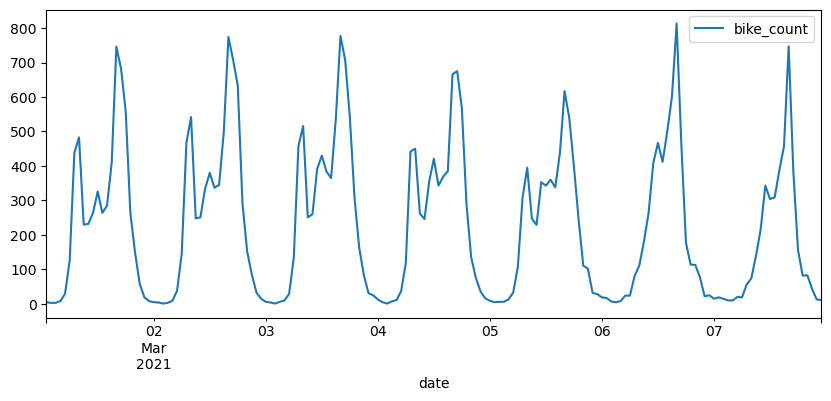

In [7]:
mask = (
    (df["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (df["date"] > pd.to_datetime("2021-03-01"))
    & (df["date"] < pd.to_datetime("2021-03-08"))
)

filtered_data = df[mask]

aggregated_data = filtered_data.groupby("date", as_index=False)["bike_count"].sum()

fig, ax = plt.subplots(figsize=(10, 4))
aggregated_data.plot(x="date", y="bike_count", ax=ax)
plt.show()

we can see a variation between workdays and weekends. (7th and 8th)

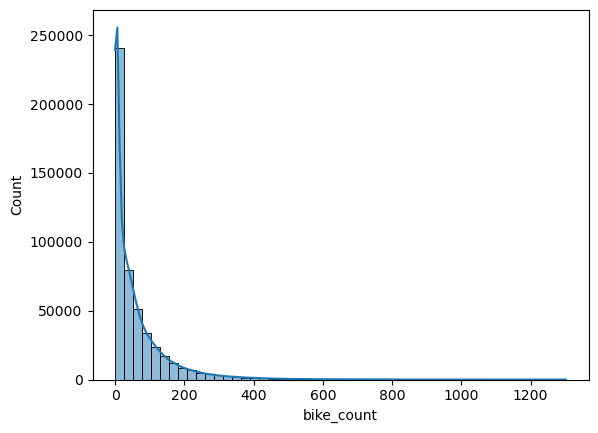

In [8]:
ax = sns.histplot(df, x="bike_count", kde=True, bins=50)

we see that the distribution for the bike_count is not normal, we now move to analyze the distribution of the log of bike_count

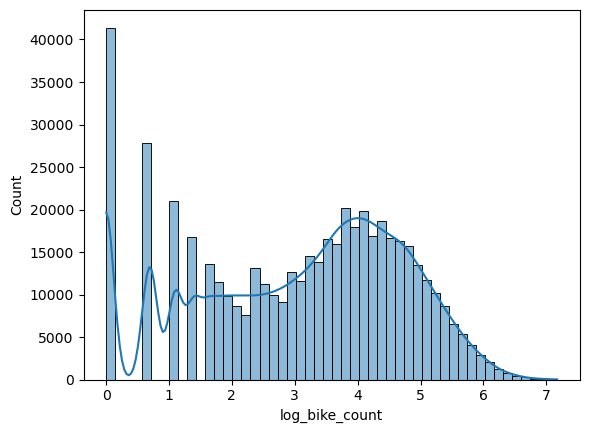

In [9]:
ax = sns.histplot(df, x="log_bike_count", kde=True, bins=50)

We see that even if not normal yet, is way better

Let's look at the bike usage thorughout the year for the top 10 counters for number of bikes used

/var/folders/3f/7638hxnj1x9g54fhyzmh1lnm0000gn/T/ipykernel_14895/1642368866.py:6: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  pd.Grouper(freq="1w", key="date")


<Axes: xlabel='date'>

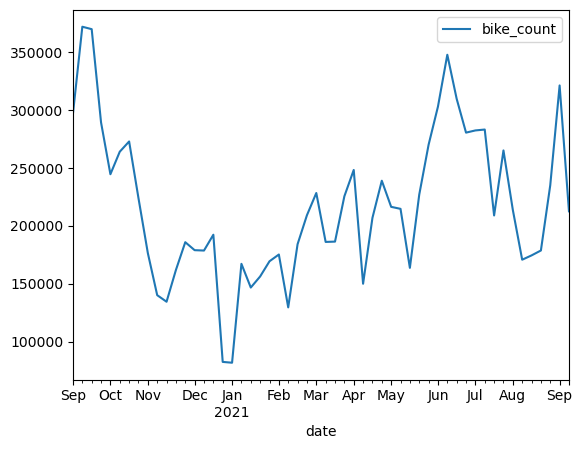

In [10]:
top_10 = df.groupby("counter_name", observed = True)["bike_count"].sum().nlargest(10).index

mask = df["counter_name"].isin(top_10)

df[mask].groupby(
    pd.Grouper(freq="1w", key="date")
)[["bike_count"]].sum().plot()

We can clearly see seasonality patterns in the time series. Later, we will account for that with appropriate variables

Finally, let's analyze the impact of COVID-19 lockdowns on the bike usage

In [11]:
#consider lockdowns
lockdown_1_start = pd.Timestamp('2020-10-30')
lockdown_1_end = pd.Timestamp('2020-12-15')

lockdown_2_start = pd.Timestamp('2021-04-03')
lockdown_2_end = pd.Timestamp('2021-05-03')

# Create a lockdown flag using conditions
df['lockdown'] = 0  # Initialize column with 0
df.loc[(df['date'] >= lockdown_1_start) & (df['date'] <= lockdown_1_end), 'lockdown'] = 1
df.loc[(df['date'] >= lockdown_2_start) & (df['date'] <= lockdown_2_end), 'lockdown'] = 1

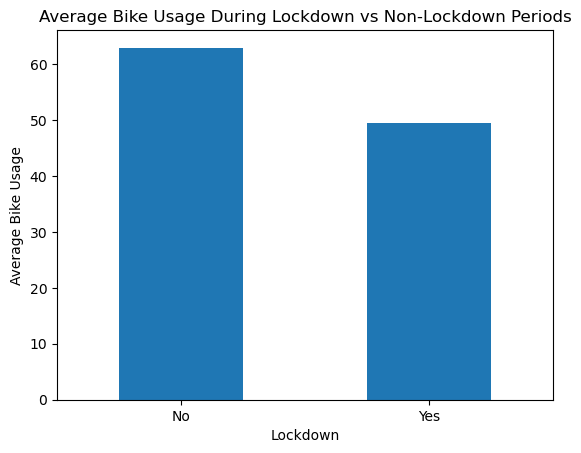

In [12]:
avg_bike_usage = df.groupby('lockdown')['bike_count'].mean()

# Plot the results
avg_bike_usage.plot(kind='bar', x='lockdown', y='bike_count')
plt.title('Average Bike Usage During Lockdown vs Non-Lockdown Periods')
plt.xlabel('Lockdown')
plt.ylabel('Average Bike Usage')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

## Weather data

Visualize the NaNs in the weather dataset

In [13]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   numer_sta  3322 non-null   int64         
 1   date       3322 non-null   datetime64[ns]
 2   pmer       3322 non-null   int64         
 3   tend       3322 non-null   int64         
 4   cod_tend   3322 non-null   int64         
 5   dd         3322 non-null   int64         
 6   ff         3322 non-null   float64       
 7   t          3322 non-null   float64       
 8   td         3322 non-null   float64       
 9   u          3322 non-null   int64         
 10  vv         3322 non-null   int64         
 11  ww         3322 non-null   int64         
 12  w1         3315 non-null   float64       
 13  w2         3312 non-null   float64       
 14  n          3166 non-null   float64       
 15  nbas       3317 non-null   float64       
 16  hbas       2869 non-null   float64       


In [14]:
threshold = 0.5
nan_percentage = weather_df.isnull().mean()
columns_with_high_nan = nan_percentage[nan_percentage > threshold].index
print(f"Columns with more than 50% NaN values: {list(columns_with_high_nan)}")


Columns with more than 50% NaN values: ['niv_bar', 'geop', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw', 'tw', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'ctype2', 'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4']


There are plenty of variables with more than 50% nan values, we will account for that later. Moreover, the dataset has a lot of variables, we will keep only the one that we believe to have more significance, such as rain, temperature, wind speed and snow height.

In [15]:
# keep only useful variables for weather data
weather_df = weather_df.drop_duplicates()
weather_df = weather_df[['date', 'ff', 't', 'ssfrai', 'etat_sol', 'ht_neige',
                        'rr1', 'rr3', 'rr6']]
weather_df = weather_df.interpolate(method='linear', limit_direction='both')
weather_df['date'] = pd.to_datetime(weather_df['date'])

In [16]:
def merge_external_data(df, weather):
    """
    Merges external weather data with the main DataFrame based on the nearest date.

    Parameters:
    ----------
    df : pandas.DataFrame
    weather : pandas.DataFrame
    Returns:
    -------
    pandas.DataFrame
    A merged DataFrame that combines `df` and `weather` based on the nearest `date` values. 
    """
    df['date'] = pd.to_datetime(df['date']).astype('datetime64[ns]')
    weather['date'] = pd.to_datetime(weather['date']).astype('datetime64[ns]')
    df["orig_index"] = np.arange(df.shape[0])
    merged_df = pd.merge_asof(
        df.sort_values("date"),
        weather.sort_values("date"),
        on="date"
    )
    merged_df = merged_df.sort_values("orig_index")
    del merged_df["orig_index"]
    return merged_df

In [17]:
merged_df = merge_external_data(df, weather_df)

Let's have a look at the correlation between variables

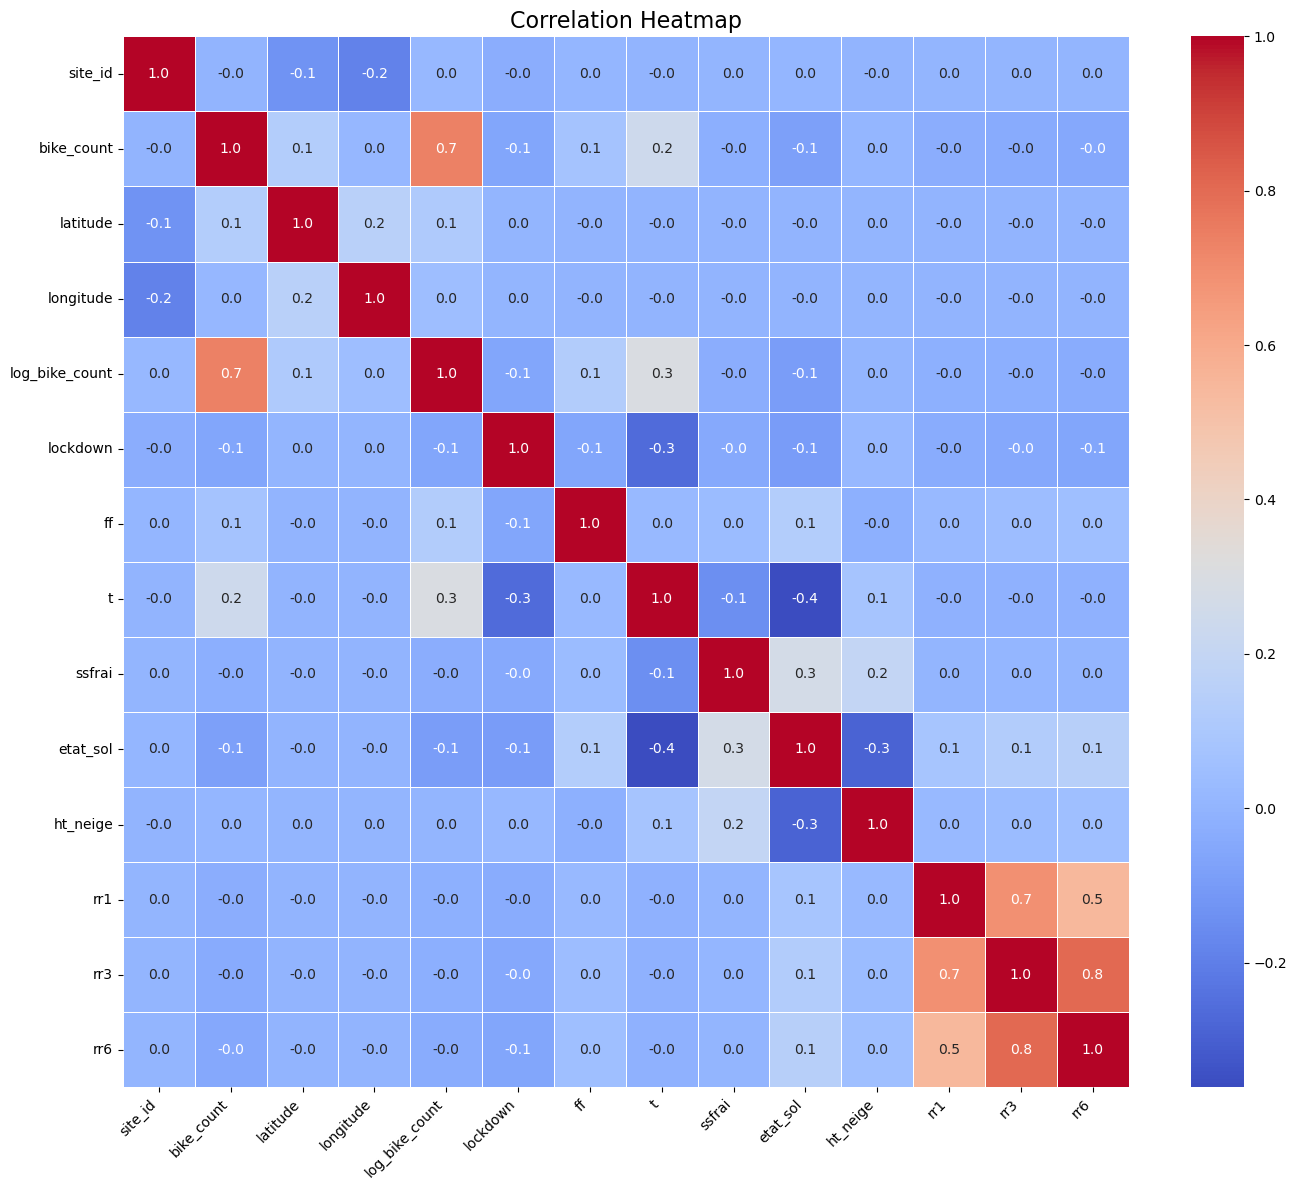

In [18]:
numerical_features = merged_df.select_dtypes(include=['number']).columns
correlation_matrix = merged_df[numerical_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".1f",
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 10},
    cbar=True
)
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

There does not seem to be a strong correlation between log_bike_count and weather variables. this is consistent with our later findings on the model results. we therefore decide not to include them in the dataset for the regression

# Model

In [19]:
def df_manipulation(df):
    """
    Enhances a DataFrame by extracting date-related features, identifying holidays, 
    and marking specific lockdown periods.

    Parameters:
    ----------
    df : pandas.DataFrame
    Returns:
    -------
    pandas.DataFrame
    """
    df['date'] = pd.to_datetime(df['date'])
    # extract useful information from dates
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    df['weekend_day'] = np.where(df['weekday'].isin([5, 6]), 1, 0)

    season_mapping = {
        3: 'spring', 4: 'spring', 5: 'spring',
        6: 'summer', 7: 'summer', 8: 'summer',
        9: 'autumn', 10: 'autumn', 11: 'autumn',
        12: 'winter', 1: 'winter', 2: 'winter'
    }

    # Map the 'month' column to seasons
    df['season'] = df['month'].map(season_mapping)

    # consider holidays in France
    holid = holidays.France(years=df['year'].unique())
    df['holidays'] = np.where(df['date'].isin(holid), 1, 0)

    #consider lockdowns
    lockdown_1_start = pd.Timestamp('2020-10-30')
    lockdown_1_end = pd.Timestamp('2020-12-15')

    lockdown_2_start = pd.Timestamp('2021-04-03')
    lockdown_2_end = pd.Timestamp('2021-05-03')

    # Create a lockdown flag using conditions
    df['lockdown'] = 0  # Initialize column with 0
    df.loc[(df['date'] >= lockdown_1_start) & (df['date'] <= lockdown_1_end), 'lockdown'] = 1
    df.loc[(df['date'] >= lockdown_2_start) & (df['date'] <= lockdown_2_end), 'lockdown'] = 1

    return df


In [20]:
df = df_manipulation(df)

/var/folders/3f/7638hxnj1x9g54fhyzmh1lnm0000gn/T/ipykernel_14895/1388188411.py:34: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['holidays'] = np.where(df['date'].isin(holid), 1, 0)


In [21]:
# create X and y
y = df['log_bike_count']
X = df.drop(columns=['bike_count', 'log_bike_count', 'counter_id',
                            'site_id', 'coordinates', 'counter_technical_id',
                            'site_name', 'date'])

X

,counter_name,counter_installation_date,latitude,longitude,lockdown,orig_index,hour,weekday,month,year,weekend_day,season,holidays
48321,28 boulevard Diderot E-O,2013-01-18,48.846028,2.375429,0,0,2,1,9,2020,0,autumn,0
48324,28 boulevard Diderot E-O,2013-01-18,48.846028,2.375429,0,1,3,1,9,2020,0,autumn,0
48327,28 boulevard Diderot E-O,2013-01-18,48.846028,2.375429,0,2,4,1,9,2020,0,autumn,0
48330,28 boulevard Diderot E-O,2013-01-18,48.846028,2.375429,0,3,15,1,9,2020,0,autumn,0
48333,28 boulevard Diderot E-O,2013-01-18,48.846028,2.375429,0,4,18,1,9,2020,0,autumn,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,254 rue de Vaugirard SO-NE,2020-11-29,48.839770,2.301980,0,496822,6,3,9,2021,0,autumn,0
929178,254 rue de Vaugirard SO-NE,2020-11-29,48.839770,2.301980,0,496823,10,3,9,2021,0,autumn,0
929181,254 rue de Vaugirard SO-NE,2020-11-29,48.839770,2.301980,0,496824,15,3,9,2021,0,autumn,0
929184,254 rue de Vaugirard SO-NE,2020-11-29,48.839770,2.301980,0,496825,22,3,9,2021,0,autumn,0


In [22]:
# Divide in train and test
df_train, df_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
df_train.head(1)

,counter_name,counter_installation_date,latitude,longitude,lockdown,orig_index,hour,weekday,month,year,weekend_day,season,holidays
413467,152 boulevard du Montparnasse O-E,2018-12-07,48.840801,2.333233,1,182128,7,4,11,2020,0,autumn,0


As we have performed the Cross Validation for all the models, to make the code less intensive, we will provide the Cross Validation only for the model that performed the best: XGBoost.

## Decision trees

In [24]:
# Decision Trees Model
variables = ['counter_name', 'year', 'month', 'weekend_day', 'weekday', 'hour', 
             'counter_installation_date', 'season']

preprocess = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown="ignore"), variables)
    ],
    remainder='passthrough'
)
pipeline = Pipeline([
    ('preprocess', preprocess), 
    ('regressor', DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=8
))])

In [25]:
pipeline.fit(df_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'year',
                                                   'month', 'weekend_day',
                                                   'weekday', 'hour',
                                                   'counter_installation_date',
                                                   'season'])])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=10, min_samples_leaf=8))])

In [26]:
y_test_pred = pipeline.predict(df_test)
rmse = MSE(y_test, y_test_pred)
print(f"The RMSE is: {np.sqrt(rmse)}")

The RMSE is: 1.0243476426880516


## Random Forest

In [27]:
# Random Forest Model
variables = ['counter_name', 'year', 'month', 'weekend_day', 'weekday', 'hour', 
             'counter_installation_date', 'season']

preprocess = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown="ignore"), variables)
    ],
    remainder='passthrough'
)
pipeline = Pipeline([
    ('preprocess', preprocess), 
    ('regressor', RandomForestRegressor(
        n_estimators=100,      
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=8
))])

In [28]:
pipeline.fit(df_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'year',
                                                   'month', 'weekend_day',
                                                   'weekday', 'hour',
                                                   'counter_installation_date',
                                                   'season'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=8))])

In [29]:
y_test_pred = pipeline.predict(df_test)
rmse = MSE(y_test, y_test_pred)
print(f"The RMSE is: {np.sqrt(rmse)}")

The RMSE is: 1.0194525567953088


# XGBoost

In [30]:
# XGBoost Model
variables = ['counter_name', 'year', 'month', 'weekend_day', 'weekday', 'hour', 
             'counter_installation_date', 'season']

preprocess = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown="ignore"), variables)
    ],
    remainder='passthrough'
)

xgb = XGBRegressor(random_state=42)

pipe = Pipeline(steps=[
                ('preprocess', preprocess),
                ('regressor', xgb)
])

In [31]:
param_grid = {
    'regressor__max_depth': [8, 12,15],
    'regressor__n_estimators': [600, 700, 800],
    'regressor__learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search_results = grid_search.fit(df_train, y_train)
print("The best parameters are ",grid_search.best_params_)  

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters are  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 8, 'regressor__n_estimators': 800}


In [32]:
xgb = grid_search.best_estimator_
xgb.fit(df_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'year',
                                                   'month', 'weekend_day',
                                                   'weekday', 'hour',
                                                   'counter_installation_date',
                                                   'season'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=800, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [33]:
y_test_pred = xgb.predict(df_test)
rmse = MSE(y_test, y_test_pred)
print(f"The RMSE is: {np.sqrt(rmse)}")

The RMSE is: 0.4823495075419905
